# Predição do Estado de uma Smart Grid

## Bibliotecas

In [12]:
# Biblioteca para coletar os dados da rede simulada
from ucimlrepo import fetch_ucirepo 

# Bibliotecas para análise e manipulação dos dados
import numpy as np
import pandas as pd

# Charts and Visualization
from matplotlib import pyplot as plt

# Machine Learning Libraries
import xgboost
from sklearn import linear_model
from sklearn.model_selection import KFold
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Domínio da Aplicação

## Exploração da Base de Dados

### Coletando os [dados simulados de estabilidade de uma rede elétrica](https://archive.ics.uci.edu/dataset/471/electrical+grid+stability+simulated+data)

In [13]:
electrical_grid_stability_simulated_data = fetch_ucirepo(id=471).data

features = electrical_grid_stability_simulated_data.features 
targets = electrical_grid_stability_simulated_data.targets

data = pd.merge(features, targets, left_index=True, right_index=True, how='outer')

### Explicando os Atributos

- tau[x]: Tempo de reação do participante (valor real no intervalo [0.5, 10] segundos). 
    - tau1 - o valor para o produtor de eletricidade;
- p[x]: Potência nominal consumida (negativa) ou produzida (positiva) (valor real). 
    - Para consumidores, no intervalo [-0.5, -2] segundos^-2;
    - p1 = abs(p2 + p3 + p4);
- g[x]: Coeficiente (gamma) proporcional à elasticidade de preço (valor real no intervalo [0.05, 1] segundos^-1). 
    - g1 - o valor para o produtor de eletricidade;
- stab: A parte real máxima da raiz da equação característica (se positiva - o sistema é linearmente instável) (valor real).
- stabf: A classificação de estabilidade do sistema (categórica: estável/instável).


### Visualização os Dados

In [14]:
data.head()

,tau1,tau2,tau3,tau4,p1,p2,p3,p4,g1,g2,g3,g4,stab,stabf
0,2.959060,3.079885,8.381025,9.780754,3.763085,-0.782604,-1.257395,-1.723086,0.650456,0.859578,0.887445,0.958034,0.055347,unstable
1,9.304097,4.902524,3.047541,1.369357,5.067812,-1.940058,-1.872742,-1.255012,0.413441,0.862414,0.562139,0.781760,-0.005957,stable
2,8.971707,8.848428,3.046479,1.214518,3.405158,-1.207456,-1.277210,-0.920492,0.163041,0.766689,0.839444,0.109853,0.003471,unstable
3,0.716415,7.669600,4.486641,2.340563,3.963791,-1.027473,-1.938944,-0.997374,0.446209,0.976744,0.929381,0.362718,0.028871,unstable
4,3.134112,7.608772,4.943759,9.857573,3.525811,-1.125531,-1.845975,-0.554305,0.797110,0.455450,0.656947,0.820923,0.049860,unstable


# Pré-Processamento dos Dados

### Eliminação do dado discreto, `stabf`

Com o objetivo de prever o próximo estado da rede, a partir do valor contínuo `stab`, temos que eliminar o valor `stabf` já que depende de `stab`.

In [15]:
data.drop(columns=['stabf'], inplace=True)

### Criação de Dados

Criar mais dados a partir das médias, para verificar novas correlações

In [16]:
data['p_std'] = (data['p1'] + data['p2'] + data['p3'] + data['p4']) / 4
data['g_std'] = (data['g1'] + data['g2'] + data['g3'] + data['g4']) / 4

### Análise das Correlações

In [17]:
correlation_matrix = data.corr()

correlation_pairs = correlation_matrix.unstack().reset_index()
correlation_pairs.columns = ['first_column', 'second_column', 'correlation']

# Remover duplicatas e auto-correlacoes
correlation_pairs = correlation_pairs[correlation_pairs['first_column'] != correlation_pairs['second_column']]
correlation_pairs = correlation_pairs.drop_duplicates(subset=['correlation'])

# Ordenar pelo valor absoluto da correlação
corr_max = correlation_pairs.sort_values(by='correlation', ascending=False)
corr_min = correlation_pairs.sort_values(by='correlation')

# Selecionar os maiores valores de correlação
print("Maiores Correlações")
print(corr_max.head(10))
print('\n')
print("Menores Correlações")
print(corr_min.head(10))

Maiores Correlações
    first_column second_column  correlation
194         stab         g_std     0.582884
134           g1         g_std     0.507925
179           g4         g_std     0.503049
164           g3         g_std     0.494952
149           g2         g_std     0.490738
162           g3          stab     0.308235
147           g2          stab     0.293601
27          tau2          stab     0.290975
132           g1          stab     0.282774
42          tau3          stab     0.280700


Menores Correlações
    first_column second_column  correlation
66            p1            p3    -0.584554
67            p1            p4    -0.579239
65            p1            p2    -0.573157
193         stab         p_std    -0.026234
117           p4          stab    -0.020786
84            p2            g2    -0.018032
37          tau3            p4    -0.017531
3           tau1          tau4    -0.017265
6           tau1            p3    -0.015924
7           tau1            p4    

## Limpeza os dados

Temos algumas providencias a serem tomadas antes de excluir ou tomar qualquer outra atitude para correlações baixas

Com os dados acima temos que os g tem grande impacto no stab e o stab tem muito impacto no stabf que é o objetivo final
Portanto o mais importante agora é ver o que fazer com os p

In [18]:
data.drop(columns=['p1', 'p2', 'p3', 'p4', 'p_std', 'g_std'], inplace=True)

# Reconhecimento de Padrões e Aprendizados

## Definição de Métodos e Classes de Apoio

In [19]:
def create_error_structure():
    return {
        "mse": [],
        "mae": [],
        "mape": []
}

class Fitter:
    def __init__(self, x_train, y_train, x_test, y_test) -> None:
        self.__x_train = x_train
        self.__y_train = y_train
        self.__x_test = x_test
        self.__y_test = y_test

    def fit_model_and_measure(self, model, data):
        model.fit(self.__x_train, self.__y_train)
        
        pred = model.predict(self.__x_test)

        data['mse'].append(mean_squared_error(self.__y_test, pred))
        data['mape'].append(np.mean(np.abs((self.__y_test - pred) / self.__y_test)) * 100)
        data['mae'].append(mean_absolute_error(self.__y_test, pred))

## Treinamento e Validação dos Modelos

In [26]:
import xgboost.sklearn

five_folds = KFold(n_splits=5, random_state=0, shuffle=True)

liner_regressor_data = create_error_structure()
tree_regressor_data = create_error_structure()
xgboost_regressor_data = create_error_structure()

STAB_COLUMN_INDEX = list(data.columns).index('stab')

for index, (train_index, test_index) in enumerate(five_folds.split(data)):
    y_train = data.values[train_index][:, STAB_COLUMN_INDEX]
    x_train = data.values[train_index]
    x_train = np.delete(x_train, STAB_COLUMN_INDEX, 1)

    y_test = data.values[test_index][:, STAB_COLUMN_INDEX]
    x_test = data.values[test_index]
    x_test = np.delete(x_test, STAB_COLUMN_INDEX, 1)

    fitter = Fitter(
        x_train=x_train,
        x_test=x_test,
        y_train=y_train,
        y_test=y_test,
    )
    
    lasso = linear_model.Lasso(alpha=0.1)

    fitter.fit_model_and_measure(lasso, data=liner_regressor_data)

    tree = DecisionTreeRegressor(max_depth=5, splitter='random', min_samples_leaf=5)

    fitter.fit_model_and_measure(tree, tree_regressor_data)

    xgb = xgboost.sklearn.XGBRegressor()

    fitter.fit_model_and_measure(xgb, xgboost_regressor_data)

[ 0.01238341  0.07250836  0.04137441 ... -0.05454145 -0.02580341
  0.04526331]
[ 0.00595357  0.01488043  0.06249051 ... -0.03606094  0.01061023
  0.06464538]
[-0.00595746  0.04986037  0.0166343  ...  0.00826022  0.02631147
 -0.03180989]
[ 0.00347088  0.02887054 -0.01738491 ...  0.02041214  0.05021177
  0.03778881]
[ 0.05534749  0.02775569 -0.02687787 ...  0.0149729   0.07299405
  0.0238916 ]


# Pós-Processamento e Conclusão

## Definindo funções de apoio

In [21]:
def create_metrics(error_structure):
    metrics = {'MSE': error_structure['mse'], 'MAE': error_structure['mae'], 'MAPE': error_structure['mape']}
    
    mean_std = {metric: (np.mean(scores), np.std(scores)) for metric, scores in metrics.items()}

    return mean_std

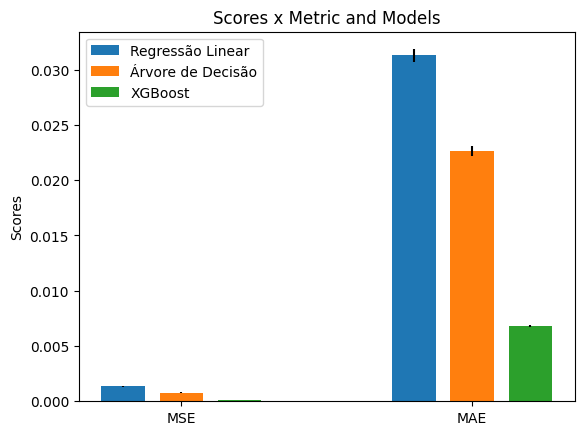

mean MSE with decision tree regressor 0.0007795258432577336
mean MAE with decision tree regressor 0.02260973192809685
mean MAPE with decision tree regressor 1164.0811071067742


mean MSE with linear regression 0.00136315142088107
mean MAE with linear regression 0.03128036901393546
mean MAPE with linear regression 931.5095547783803


mean MSE with xgboost regressor 8.129997450321227e-05
mean MAE with xgboost regressor 0.006803219858616066
mean MAPE with xgboost regressor 326.8171605873881


In [24]:
# Regressão Linear

linear_mean_std = create_metrics(liner_regressor_data)
tree_mean_std = create_metrics(tree_regressor_data)
xgboost_mean_std = create_metrics(xgboost_regressor_data)

# Plotando os gráficos

metrics_labels = ['MSE', 'MAE']

width = 0.3
x = np.arange(len(metrics_labels))

fig, ax = plt.subplots()

rects1 = ax.bar(x - (width * 2)/3, [linear_mean_std[metric][0] for metric in metrics_labels], width/2, label='Regressão Linear', yerr=[linear_mean_std[metric][1] for metric in metrics_labels])
rects2 = ax.bar(x, [tree_mean_std[metric][0] for metric in metrics_labels], width/2, label='Árvore de Decisão', yerr=[tree_mean_std[metric][1] for metric in metrics_labels])
rects3 = ax.bar(x + (width * 2)/3, [xgboost_mean_std[metric][0] for metric in metrics_labels], width/2, label='XGBoost', yerr=[xgboost_mean_std[metric][1] for metric in metrics_labels])

ax.set_ylabel('Scores')
ax.set_title('Scores x Metric and Models')
ax.set_xticks(x)
ax.set_xticklabels(metrics_labels)
ax.legend()


plt.show()

for index in tree_mean_std:
  print(f'mean {index} with decision tree regressor {tree_mean_std[index][0]}')

print("\n")

for index in linear_mean_std:
  print(f'mean {index} with linear regression {linear_mean_std[index][0]}')

print("\n")

for index in xgboost_mean_std:
  print(f'mean {index} with xgboost regressor {xgboost_mean_std[index][0]}')

# Conclusão

Responder à pergunta: "Você acredita que será possível entregar tudo que prometeu no documento da Proposta?"


Sim, por mais que esteja apenas no começo do projeto, já é possivel fazer algumas análises utilizando regressão linear e arvore de regressão como visto em aula, com o que já temos fica facil crial pipelines para os ajustes nos dados e também abre a possibilidade para random forests. Com o objetivo final de evitar overfitting e garantir também que seja possivel obter respostas e tomadas de decisões razoáveis em relação aos dados estabelecidos.